In [164]:
import pandas as pd
from glob import glob
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [128]:
def wrangle(filepath):
    #extract timestamp and value_type from dataset 
    df=pd.read_csv(filepath)
    
    #extract p2 type from value_type
    df=df[df['value_type']=='P2'] 
    
    df=df[['timestamp','value']]
    
    #set index to timestamp
    df=df.set_index('timestamp')
    
    df.index=pd.to_datetime(df.index)
    
    #rename value to p2
    df.rename(columns={'value':'P2'},inplace=True)
    
    #setting the timezone to the correct one
    #df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    
    #removing outliers
    df=df[df['P2']<500.4]
    
    #resampling by 1H and fill null value
    df=df['P2'].resample('1H').mean().fillna(method='ffill').to_frame()
    
    #create a new column where the values are of the previous hour
    df['P2.L1']=df['P2'].shift(1)
    df.dropna(inplace=True)
    
    return df

In [120]:
files=glob("/Users/bambino/Documents/DATASETS/2020_sensor_data_archive_*.csv")
files

['/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_august.csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_december.csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_february.csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_january .csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_march.csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_november.csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_october.csv',
 '/Users/bambino/Documents/DATASETS\\2020_sensor_data_archive_september.csv']

In [129]:
dfs=[wrangle(i) for i in files]

In [130]:
df=pd.concat(dfs)

In [131]:
df.shape

(3659, 2)

In [132]:
df.head()

,P2,P2.L1
timestamp,,
2020-08-12 10:00:00+00:00,39.545263,38.463043
2020-08-12 11:00:00+00:00,39.326471,39.545263
2020-12-01 01:00:00+00:00,39.833333,41.300000
2020-12-01 02:00:00+00:00,43.595833,39.833333
2020-12-01 03:00:00+00:00,50.015385,43.595833


<AxesSubplot:>

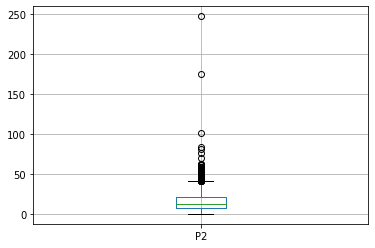

In [125]:
df.boxplot()

We notice there are a lot of outliers in our data from the boxplot above.<br>
From the information available online, Particulate matter ranges from 0 to 500.4. Our data contains values above 500, this means there was an error in the data entry.<br>
The wrangle function will be modified to remove these outliers

<AxesSubplot:xlabel='timestamp'>

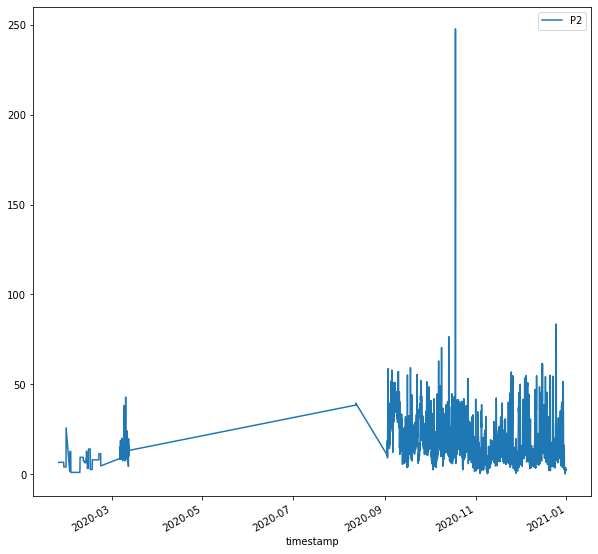

In [126]:
#time series plot
fig,ax=plt.subplots(figsize=(10,10))
df.plot(kind='line',ax=ax)

For this project, I am trying to predict PM 2.5 readings.<br>
What to consider is, will I be predicting the readings every hour, second or minute?<br>
Resample method will be used to get the readings by hour.<br>
In time series data, we can't have any null values, so any null value should be taken care of.<br>
This will be modified in the wrangle function.<br>

In [105]:
#rolling avearage

Rolling average is the mean value of multiple subsets of numbers in a dataset. <br>
These averages roll, giving me a sense for how the data is changing in relation to any kind of static construct. In this case, and in many data science applications, that construct is time. Calculating rolling averages is helpful for making accurate forecasts about the ways data will change in the future.



In [106]:
#calculating rolling average

Our data is already resampled into hours.<br>
We can calculate our rolling average by the number of hours in a week, 24*7=168.<br>

In [110]:
df['P2'].rolling(168).mean()

timestamp
2020-08-12 09:00:00+00:00          NaN
2020-08-12 10:00:00+00:00          NaN
2020-08-12 11:00:00+00:00          NaN
2020-12-01 00:00:00+00:00          NaN
2020-12-01 01:00:00+00:00          NaN
                               ...    
2020-09-30 19:00:00+00:00    22.988902
2020-09-30 20:00:00+00:00    23.141478
2020-09-30 21:00:00+00:00    23.248585
2020-09-30 22:00:00+00:00    23.349636
2020-09-30 23:00:00+00:00    23.366089
Name: P2, Length: 3667, dtype: float64

<AxesSubplot:xlabel='timestamp'>

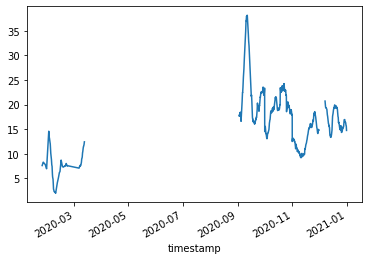

In [111]:
df['P2'].rolling(168).mean().plot()

Remember that when you train a machine learning model, we need a target and predictor variable but in time series data, we only have one column so what to do?<br>
A new column will be created called p2.l1, it'll contains values from the previous hour values of p2.<br>
This will be modified in our wrangle function.<br>

In [133]:
df.head()

,P2,P2.L1
timestamp,,
2020-08-12 10:00:00+00:00,39.545263,38.463043
2020-08-12 11:00:00+00:00,39.326471,39.545263
2020-12-01 01:00:00+00:00,39.833333,41.300000
2020-12-01 02:00:00+00:00,43.595833,39.833333
2020-12-01 03:00:00+00:00,50.015385,43.595833


In [134]:
#next, we will calculate the correlation matrix and plot a scatter plot

In [135]:
df.corr()

,P2,P2.L1
P2,1.000000,0.856066
P2.L1,0.856066,1.000000


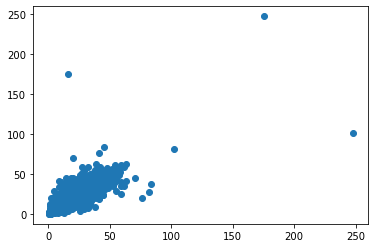

In [137]:
plt.scatter(df['P2'],df['P2.L1']);

## Split

In [145]:
target = "P2"
y = df[target]
X = df.drop(columns=target)

In [146]:
X_train,X_test, y_train, y_test=train_test_split(X,y,test_size=0.20,random_state=42)

## Baseline model

In [147]:
y_mean=y_train.mean()
y_pred_baseline = [y.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline,y_train)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 16.21
Baseline MAE: 9.51


## Iterate

In [148]:
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [156]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

In [161]:
y_pred_test

array([ 15.27910655,  50.1646554 ,  36.97150508,   9.06328882,
        13.88988227,   2.91336315,  10.5934489 ,  17.02954347,
         6.59376898,  38.90873166,  28.786979  ,  26.98043834,
        25.27822677,  10.66117129,  20.17049386,   8.98275408,
        12.63375995,  33.39904127,  14.20286956,   9.94184963,
        22.65424256,  11.17886325,  10.14135615,  36.77016823,
         9.06328882,  19.8982355 ,  49.64133875,  21.58392631,
         6.49036073,  11.18856925,   9.86863623,   2.91336315,
        23.55954218,   7.66125219,   9.09001171,  14.34453749,
         5.649714  ,  12.65597499,  15.70024276,   5.5754024 ,
        18.05389444,   5.40444911,  10.92927558,  25.73493514,
        12.05039557,  19.88648218,  31.42449177,  10.29327395,
         6.74608468,   6.4161469 ,   7.57522645,  14.67399779,
        10.29327395,  19.73971257,   6.96238253,  11.17894692,
         8.97177207,  14.33465368,   2.91336315,  22.68464204,
        15.15668101,   9.06328882,  15.33035593,   5.46

## Evaluate

In [157]:
training_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 3.73
Test MAE: 3.7


Both our training and test data is performing way better than our baseline model

In [155]:
intercept = model.intercept_
coefficient = model.coef_

print("P2 =",intercept, '+','(',coefficient, "*", "P2.L1)")

P2 = 2.0348023385958456 + ( [0.87856081] * P2.L1)


In [163]:
df_pred_test = pd.DataFrame(
    {'y_test':y_test,
    'y_pred':y_pred_test}
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2020-12-13 02:00:00+00:00,15.148696,15.279107
2020-12-12 05:00:00+00:00,40.316667,50.164655
2020-12-07 04:00:00+00:00,32.949167,36.971505
2020-02-20 01:00:00+00:00,8.000000,9.063289
2020-11-22 22:00:00+00:00,14.215417,13.889882
